In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [2]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1a. Create Data for Toy Problem

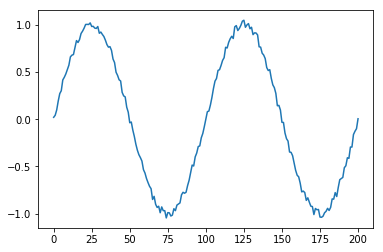

In [3]:
seed_int=123

rng = np.random.RandomState(seed_int)

def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*rng.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 1b. Prepare Input Data to Train the Model

In [4]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 1b. Split Data into Training and Valdiation Set 

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation, random_state=seed_int)

# 2a. Prepare Model Functions for Graph

In [18]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)
    
def bias_variable(shape, name=None, init_fun=tf.zeros):
    initial = init_fun(shape, dtype=tf.float32)
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)

# 2b. Manual Inference Functions

In [7]:
def infere_RNN(x, n_batch, maxlen=None, n_hidden=None, n_out=None, n_in=None):
    #########################################################################
    # Write an RNN that takes as input data a matrix x
    # with shape=[n_batch, maxlen, n_in])
    #########################################################################
    return y

def infere_LSTM(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    #########################################################################
    # Write an LSTM that takes as input data a matrix x
    # with shape=[n_batch, maxlen, n_in])
    #########################################################################
    return y, [V, c]

def infere_GRU(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    #########################################################################
    # Write a GRU that takes as input data a matrix x
    # with shape=[n_batch, maxlen, n_in])
    #########################################################################
    return y

In [19]:
def infere_RNN(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('RNN'):
        # going to combine this as (x, U)
        U = weight_variable([n_in, n_hidden], 'U') 
        W = weight_variable([n_hidden, n_hidden], 'W')
        b = bias_variable([n_hidden], 'b')
        hlist = []
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            h_i = tf.tanh(tf.matmul(x[:, i, :], U) + tf.matmul(h_prev, W) + b)
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, U, W, b, c]

def infere_GRU(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('GRU'):
        # going to combine this as (x, U)
        # RESET UNITS
        Ur = weight_variable([n_in, n_hidden], 'Ur') 
        Wr = weight_variable([n_hidden, n_hidden], 'Wr')
        br = bias_variable([n_hidden], 'br')
        # UPDATE UNITS
        Uz = weight_variable([n_in, n_hidden], 'Uz') 
        Wz = weight_variable([n_hidden, n_hidden], 'Wz')
        bz = bias_variable([n_hidden], 'bz', init_fun=tf.ones) # limit of the RNN is recovered for f=1, i.e. large bias
        # HIDDEN UNITS (new memory)
        Uh = weight_variable([n_in, n_hidden], 'Uh') 
        Wh = weight_variable([n_hidden, n_hidden], 'Wh')
        bh = bias_variable([n_hidden], 'bh')
        # NEW MEMORY UNITS ('activation' units)
        # Initialize lists
        hlist = []
    
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            r_i = tf.sigmoid(tf.matmul(x[:, i, :], Ur) + tf.matmul(h_prev, Wr) + br) 
            z_i = tf.sigmoid(tf.matmul(x[:, i, :], Uz) + tf.matmul(h_prev, Wz) + bz) 
            ht_i = tf.tanh(tf.matmul(x[:, i, :], Uh) + r_i*tf.matmul(h_prev, Wh) + bh)
            h_i = z_i*h_prev + (1 - z_i)*ht_i
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, c]

def infere_LSTM(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('LSTM'):
        # going to combine this as (x, U)
        # INPUT UNITS
        Ui = weight_variable([n_in, n_hidden], 'Ui') 
        Wi = weight_variable([n_hidden, n_hidden], 'Wi')
        Vi = weight_variable([n_hidden, n_hidden], 'Vi')
        bi = bias_variable([n_hidden], 'bi')
        # OUTPUT UNITS
        Uo = weight_variable([n_in, n_hidden], 'Uo') 
        Wo = weight_variable([n_hidden, n_hidden], 'Wo')
        Vo = weight_variable([n_hidden, n_hidden], 'Vo')
        bo = bias_variable([n_hidden], 'bo')
        # FORGET UNITS
        Uf = weight_variable([n_in, n_hidden], 'Uf') 
        Wf = weight_variable([n_hidden, n_hidden], 'Wf')
        Vf = weight_variable([n_hidden, n_hidden], 'Vf')
        bf = bias_variable([n_hidden], 'bf', init_fun=tf.ones) # limit of the RNN is recovered for f=1, i.e. large bias
        # NEW MEMORY UNITS ('activation' units)
        Ua = weight_variable([n_in, n_hidden], 'Ua') 
        Wa = weight_variable([n_hidden, n_hidden], 'Wa')
        ba = bias_variable([n_hidden], 'ba')
        # Initialize lists
        hlist = []
        clist = []
      
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        c_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
                c_prev = clist[-1]
            a_i = tf.tanh(   tf.matmul(x[:, i, :], Ua) + tf.matmul(h_prev, Wa)                         + ba)
            f_i = tf.sigmoid(tf.matmul(x[:, i, :], Uf) + tf.matmul(h_prev, Wf) + tf.matmul(c_prev, Vf) + bf) 
            i_i = tf.sigmoid(tf.matmul(x[:, i, :], Ui) + tf.matmul(h_prev, Wi) + tf.matmul(c_prev, Vi) + bi) 
            c_i = i_i * a_i + f_i * c_prev
            o_i = tf.sigmoid(tf.matmul(x[:, i, :], Uo) + tf.matmul(h_prev, Wo) + tf.matmul(c_i, Vo)    + bo)
            h_i = o_i * tf.tanh(c_i)
            hlist.append(h_i)
            clist.append(c_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, c]


# 2c. Loss and training function

In [20]:
def loss_fun(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step



# 3. Define Graph

In [21]:
tf.reset_default_graph()

maxlen = 25
n_hidden = 20
n_out = 1
n_in = 1

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
#y = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
#y, cvars = infere_RNN(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
y, cvars = infere_LSTM(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
loss = loss_fun(y, t)
train_step = training(loss)


# 4. Run Computational Graph

In [22]:
epochs = 300
batch_size = 10

tf.set_random_seed(seed_int)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train, random_state = seed_int)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss:  0.565263
epoch: 1  validation loss:  0.502266
epoch: 2  validation loss:  0.294118
epoch: 3  validation loss:  0.318946
epoch: 4  validation loss:  0.265462
epoch: 5  validation loss:  0.25665
epoch: 6  validation loss:  0.224483
epoch: 7  validation loss:  0.204235
epoch: 8  validation loss:  0.179147
epoch: 9  validation loss:  0.160925
epoch: 10  validation loss:  0.146261
epoch: 11  validation loss:  0.131557
epoch: 12  validation loss:  0.114974
epoch: 13  validation loss:  0.101932
epoch: 14  validation loss:  0.0908858
epoch: 15  validation loss:  0.0812348
epoch: 16  validation loss:  0.0729109
epoch: 17  validation loss:  0.0656253
epoch: 18  validation loss:  0.0591869
epoch: 19  validation loss:  0.0534511
epoch: 20  validation loss:  0.0482656
epoch: 21  validation loss:  0.0435054
epoch: 22  validation loss:  0.039062
epoch: 23  validation loss:  0.0348332
epoch: 24  validation loss:  0.0307255
epoch: 25  validation loss:  0.0266558
epoch: 26  v

epoch: 201  validation loss:  0.000861733
epoch: 202  validation loss:  0.000861174
epoch: 203  validation loss:  0.000860612
epoch: 204  validation loss:  0.000860052
epoch: 205  validation loss:  0.000859492
epoch: 206  validation loss:  0.00085893
epoch: 207  validation loss:  0.00085837
epoch: 208  validation loss:  0.00085781
epoch: 209  validation loss:  0.00085725
epoch: 210  validation loss:  0.000856692
epoch: 211  validation loss:  0.000856134
epoch: 212  validation loss:  0.000855578
epoch: 213  validation loss:  0.000855023
epoch: 214  validation loss:  0.00085447
epoch: 215  validation loss:  0.000853919
epoch: 216  validation loss:  0.000853369
epoch: 217  validation loss:  0.000852823
epoch: 218  validation loss:  0.000852279
epoch: 219  validation loss:  0.000851738
epoch: 220  validation loss:  0.0008512
epoch: 221  validation loss:  0.000850665
epoch: 222  validation loss:  0.000850134
epoch: 223  validation loss:  0.000849608
epoch: 224  validation loss:  0.000849083

# 5. Show Results

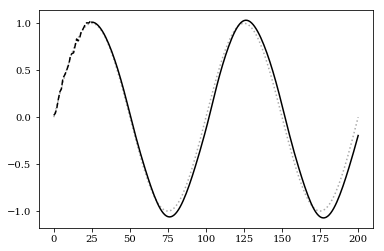

In [23]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# 7. Inspect Variables

#### What happened to the variables in RNN cell?

In [14]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)

(20, 1)
(1, 20)


In [15]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='RNN')

[<tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=float32_ref>]

In [16]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'V:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'V/Adam:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'V/Adam_1:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'c/Adam:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'c/Adam_1:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/U/Adam_1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/W/Adam_1:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'RNN/b/Adam_1:0' shape=(20,) dtype=fl